<a href="https://colab.research.google.com/github/xhorn-pan/xhorn-pan/blob/main/final_vgg_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# python env prepare


In [ ]:
!pip uninstall -y tensorflow-gpu tensorflow 
!pip install -q tf-nightly

In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

# Dataset prepare

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
%load_ext tensorboard
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras import layers
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import pathlib
data_dir = "./ds_vgg"

TensorFlow 2.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#file_root = tf.keras.utils.get_file('vgg', 'https://cise.ufl.edu/~jdsmith/vggface2_test_64x64.zip', extract=True, archive_format='zip', cache_dir='./vgg_cache')

files_root = pathlib.Path("/content/drive/My Drive/Colab Notebooks/vggface2_test_64x64.zip")

import zipfile
with zipfile.ZipFile(files_root, 'r') as zip_ref:
  zip_ref.extractall(data_dir)

In [ ]:
data_root = pathlib.Path(data_dir + "/test")
all_faces_paths = list(data_root.glob("*/*"))#[0::2]
#all_faces_paths = all_faces_paths[0::2]
all_faces_paths = [str(path) for path in all_faces_paths]


train_dataset = [path for i, path in enumerate(all_faces_paths) if i % 10 != 0]
test_dataset = [path for i, path in enumerate(all_faces_paths) if i % 10 == 0]

trs, ts = len(train_dataset), len(test_dataset)
batch_size = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

#load dataset
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = (tf.cast(image, tf.float32) - 127.5) / 127.5 # normalize to [-1,1] range
  
  return image

train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache()
train_dataset = train_dataset.shuffle(buffer_size=trs).batch(batch_size,
                           drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).cache()
test_dataset = test_dataset.shuffle(buffer_size=trs).batch(batch_size,
                           drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

# GAN model

In [ ]:
k_initializer = tf.initializers.TruncatedNormal(stddev=0.02)
drop_rate = 0.3

# GAN models
def make_generate_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4096, use_bias=False, kernel_initializer=k_initializer,input_shape=(512,)))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.ReLU())
    #model.add(layers.Dropout(drop_rate))
    
    model.add(layers.Reshape([4,4,256]))

    model.add(layers.Conv2DTranspose(512, (4,4), strides=(2,2), kernel_initializer=k_initializer, padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.ReLU())
    #model.add(layers.Dropout(drop_rate))

    model.add(layers.Conv2DTranspose(256, (4,4), strides=(2,2), kernel_initializer=k_initializer, padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.ReLU())
    #model.add(layers.Dropout(drop_rate))

    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), kernel_initializer=k_initializer, padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.ReLU())
    #model.add(layers.Dropout(drop_rate))

    model.add(layers.Conv2DTranspose(64, (4,4), strides=(2,2), kernel_initializer=k_initializer, padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (4,4), kernel_initializer=k_initializer, padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (4,4), kernel_initializer=k_initializer, padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.ReLU())
    #model.add(layers.Dropout(drop_rate))

    model.add(layers.Conv2DTranspose(3, (4, 4), kernel_initializer=k_initializer, padding='same', use_bias=False, activation='tanh'))
    #model.add(layers.Dropout(drop_rate))
    
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (4,4), strides=(2,2), kernel_initializer=k_initializer, padding='same', input_shape=[64,64,3]))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(drop_rate))

    model.add(layers.Conv2D(32, (4,4), kernel_initializer=k_initializer, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(64, (4,4), strides=(2,2), kernel_initializer=k_initializer, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4,4), strides=(2,2), kernel_initializer=k_initializer, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(drop_rate))

    model.add(layers.Conv2D(256, (4,4), strides=(2,2), kernel_initializer=k_initializer, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.LeakyReLU(alpha=0.2))
    #model.add(layers.Dropout(drop_rate))

    model.add(layers.Conv2D(512, (4,4), strides=(2,2), kernel_initializer=k_initializer, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.09))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    #model.add(layers.Dropout(drop_rate))
    model.add(layers.Dense(1, kernel_initializer=k_initializer))
    
    return model

generator = make_generate_model()
generator.summary()
discriminator = make_discriminator_model()
discriminator.summary()
tf.keras.utils.plot_model(generator, to_file="generator.png", show_shapes=True, show_layer_names=False)
tf.keras.utils.plot_model(discriminator, to_file="discriminator.png", show_shapes=True, show_layer_names=False)

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy =tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



generator_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5) 
discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
# generator_optimizer = tf.keras.optimizers.RMSprop(1e-4)
# discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4) 

checkpoint_dir = data_dir + "/chkpts"
checkpoint_prefix=os.path.join(checkpoint_dir, 'chpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)


noise_dim = 512
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss


def test_step():
  g_loss = tf.keras.metrics.Mean()
  d_loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    noise = tf.random.normal([batch_size, noise_dim])
    generated_images = generator(noise, training=False)
    real_output = discriminator(test_x, training=False)
    fake_output = discriminator(generated_images, training=False)
    g_loss(generator_loss(fake_output))
    d_loss(discriminator_loss(real_output, fake_output))
  return g_loss.result(), d_loss.result()



save_epoch = 1

def train(dataset, epochs):
  start_time = time.time()
  gl = []
  dl = []
  gtl = []
  dtl = []
  for epoch in range(1, epochs + 1):
    g_loss = tf.keras.metrics.Mean()
    d_loss = tf.keras.metrics.Mean()
    gle = []
    dle = []
    for images in dataset:
      #print('.', end='')
      gen_loss, disc_loss = train_step(images)
      g_loss(gen_loss)
      d_loss(disc_loss)
    gl.append(g_loss.result())
    dl.append(d_loss.result())
    print('step {}, time: {} sec'.format(epoch, time.time()-start_time))
    start_time = time.time()
    #print('')
    if epoch % save_epoch == 0:
      generate_and_save_images(generator, epoch, seed)
      save_loss_image(gl, dl)
      checkpoint.save(file_prefix = checkpoint_prefix)
      t_gl, t_dl = test_step()
      gtl.append(t_gl)
      dtl.append(t_dl)
      save_loss_image_test(gtl, dtl)
      

def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  predictions = (predictions + 1.0) / 2.0
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')
  plt.savefig('/content/drive/My Drive/ml_logs/gan_image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def save_loss_image_test(g_loss_hist, d_loss_hist):
  x = len(g_loss_hist)
  y = len(d_loss_hist)
  x = np.arange(x)
  plt.plot(x, g_loss_hist, label="G_loss-test")
  plt.plot(x, d_loss_hist, label="D_loss-test")
  plt.legend(loc='upper right')
  plt.savefig('/content/drive/My Drive/ml_logs/gan_loss_test.png')
  plt.show()

def save_loss_image(g_loss_hist, d_loss_hist):
  x = len(g_loss_hist)
  y = len(d_loss_hist)
  x = np.arange(x)
  plt.plot(x, g_loss_hist, label="G_loss-train")
  plt.plot(x, d_loss_hist, label="D_loss-train")
  plt.legend(loc='upper right')
  plt.savefig('/content/drive/My Drive/ml_logs/gan_loss_train.png')
  plt.show()

In [ ]:
train(train_dataset, 200)

In [ ]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/vgg-gan'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint.save(file_prefix = checkpoint_prefix)  

'/content/drive/My Drive/Colab Notebooks/vgg-gan/ckpt-1'

In [ ]:
generator_json = generator.to_json()
discriminator_json = discriminator.to_json()


with open('/content/drive/My Drive/Colab Notebooks/vgg-gan/generator.json', 'w') as f:
  f.write(generator_json)
with open('/content/drive/My Drive/Colab Notebooks/vgg-gan/discriminator.json', 'w') as f:
  f.write(discriminator_json)
    # save model weights
discriminator.save('/content/drive/My Drive/Colab Notebooks/vgg-gan/discriminator.h5')
generator.save('/content/drive/My Drive/Colab Notebooks/vgg-gan/generator.h5')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/vgg-gan/discriminator.h5')



In [ ]:
!pip install keract fancyimpute

In [ ]:
from keract import get_activations

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy =tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)
generator_optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4, beta_1=0.5)
new_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=generator_optimizer)

conv2d/Identity:0 (1, 32, 32, 64) 


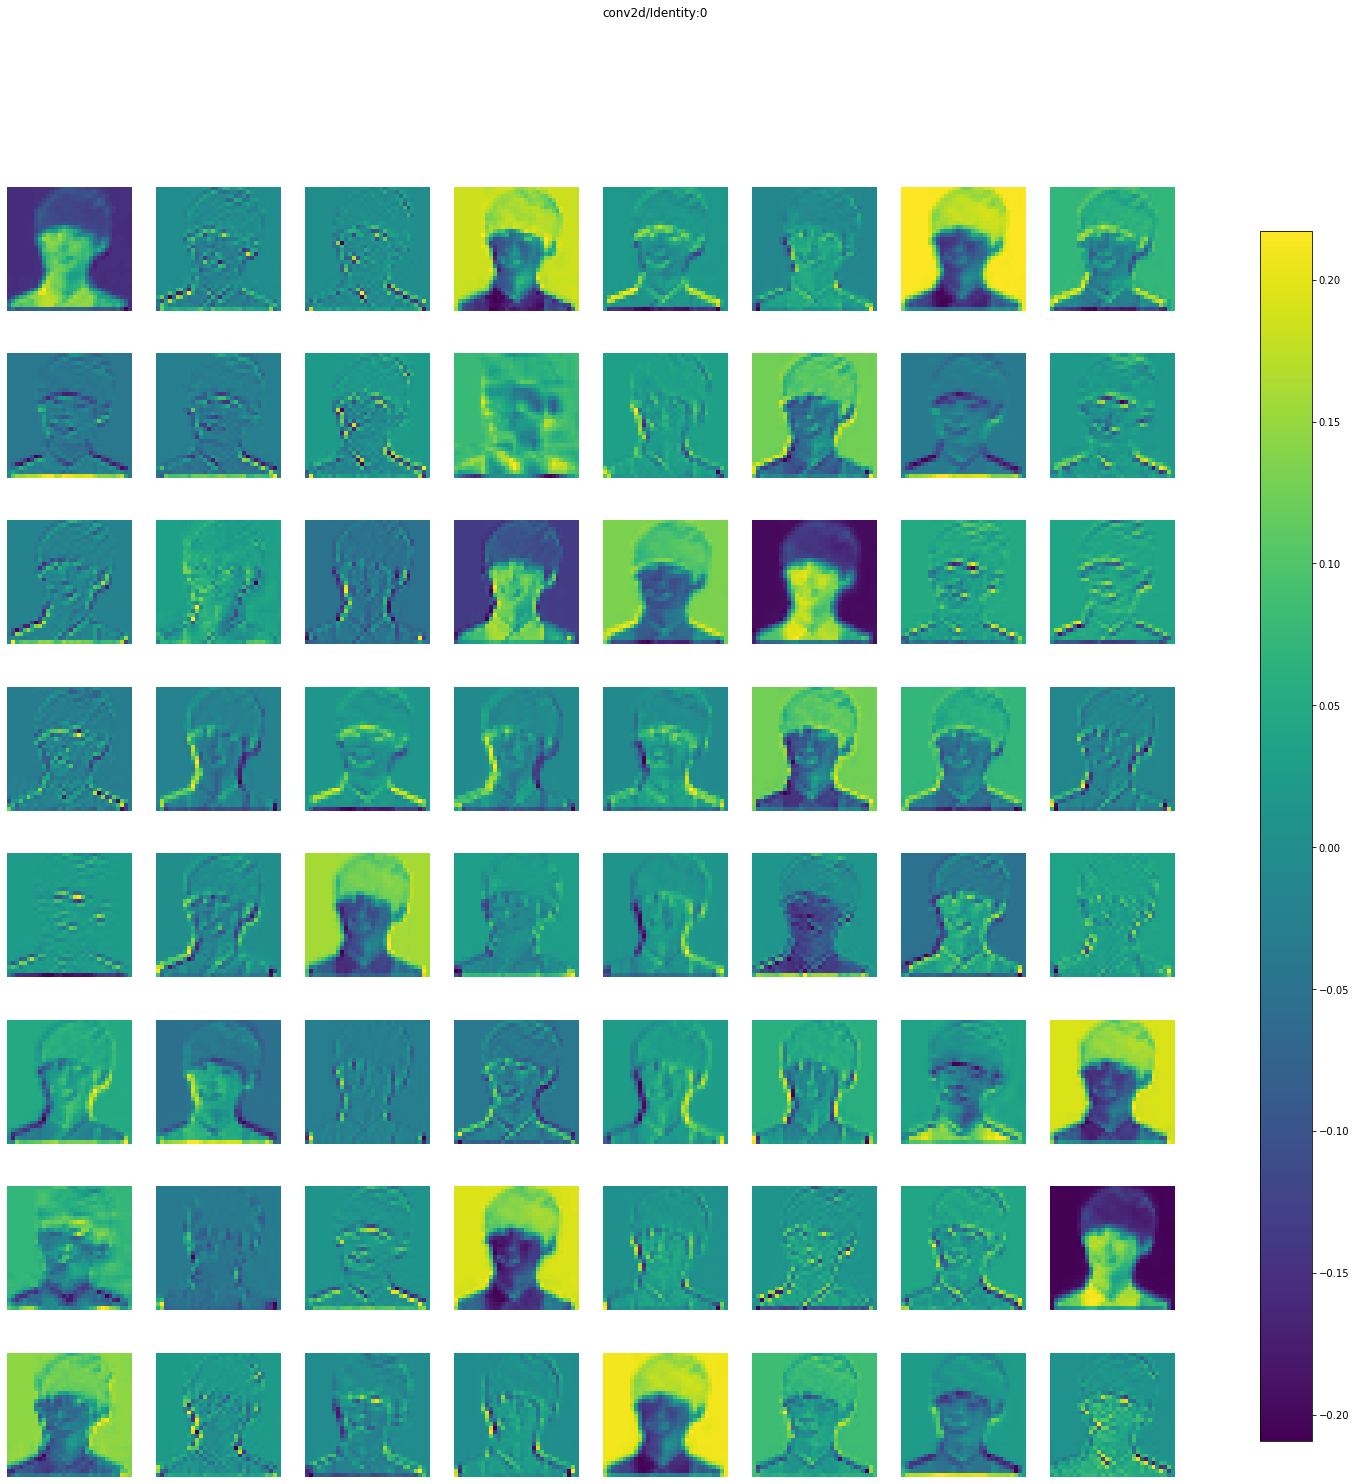

batch_normalization_4/Identity:0 (1, 32, 32, 64) 


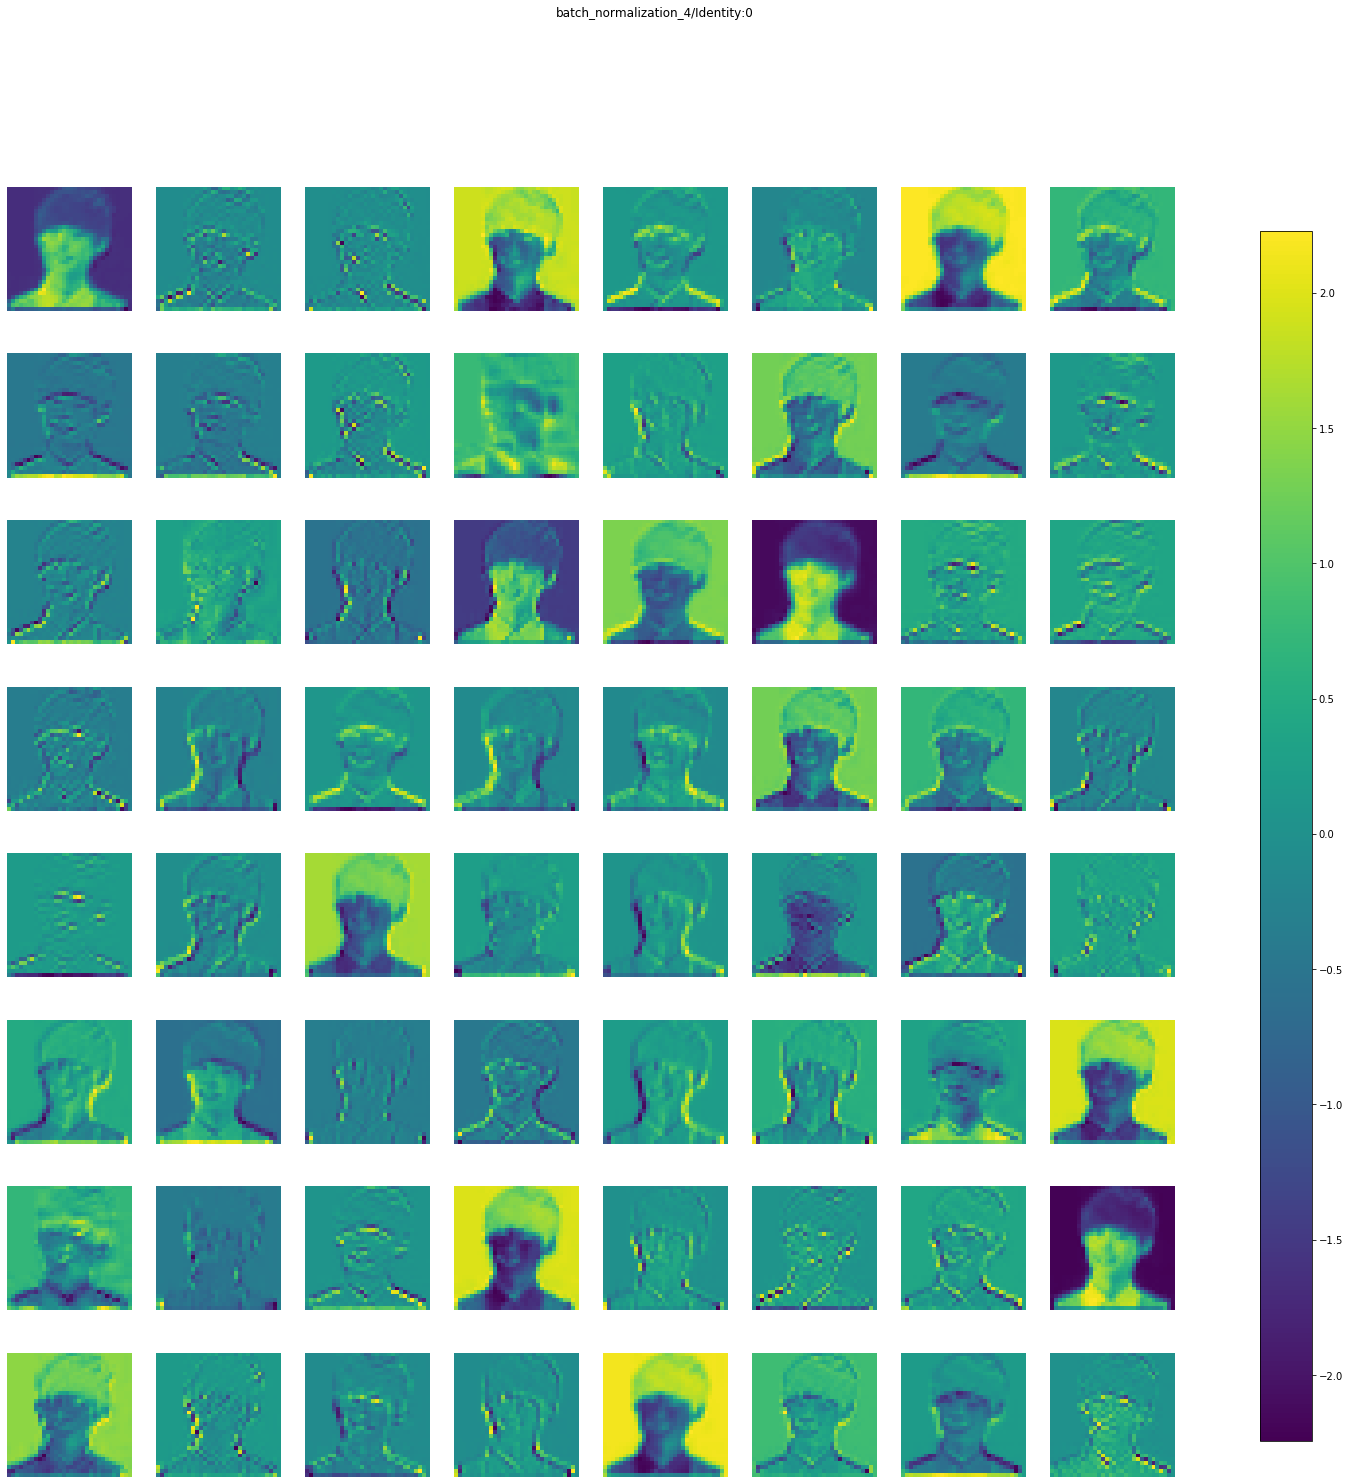

leaky_re_lu/Identity:0 (1, 32, 32, 64) 


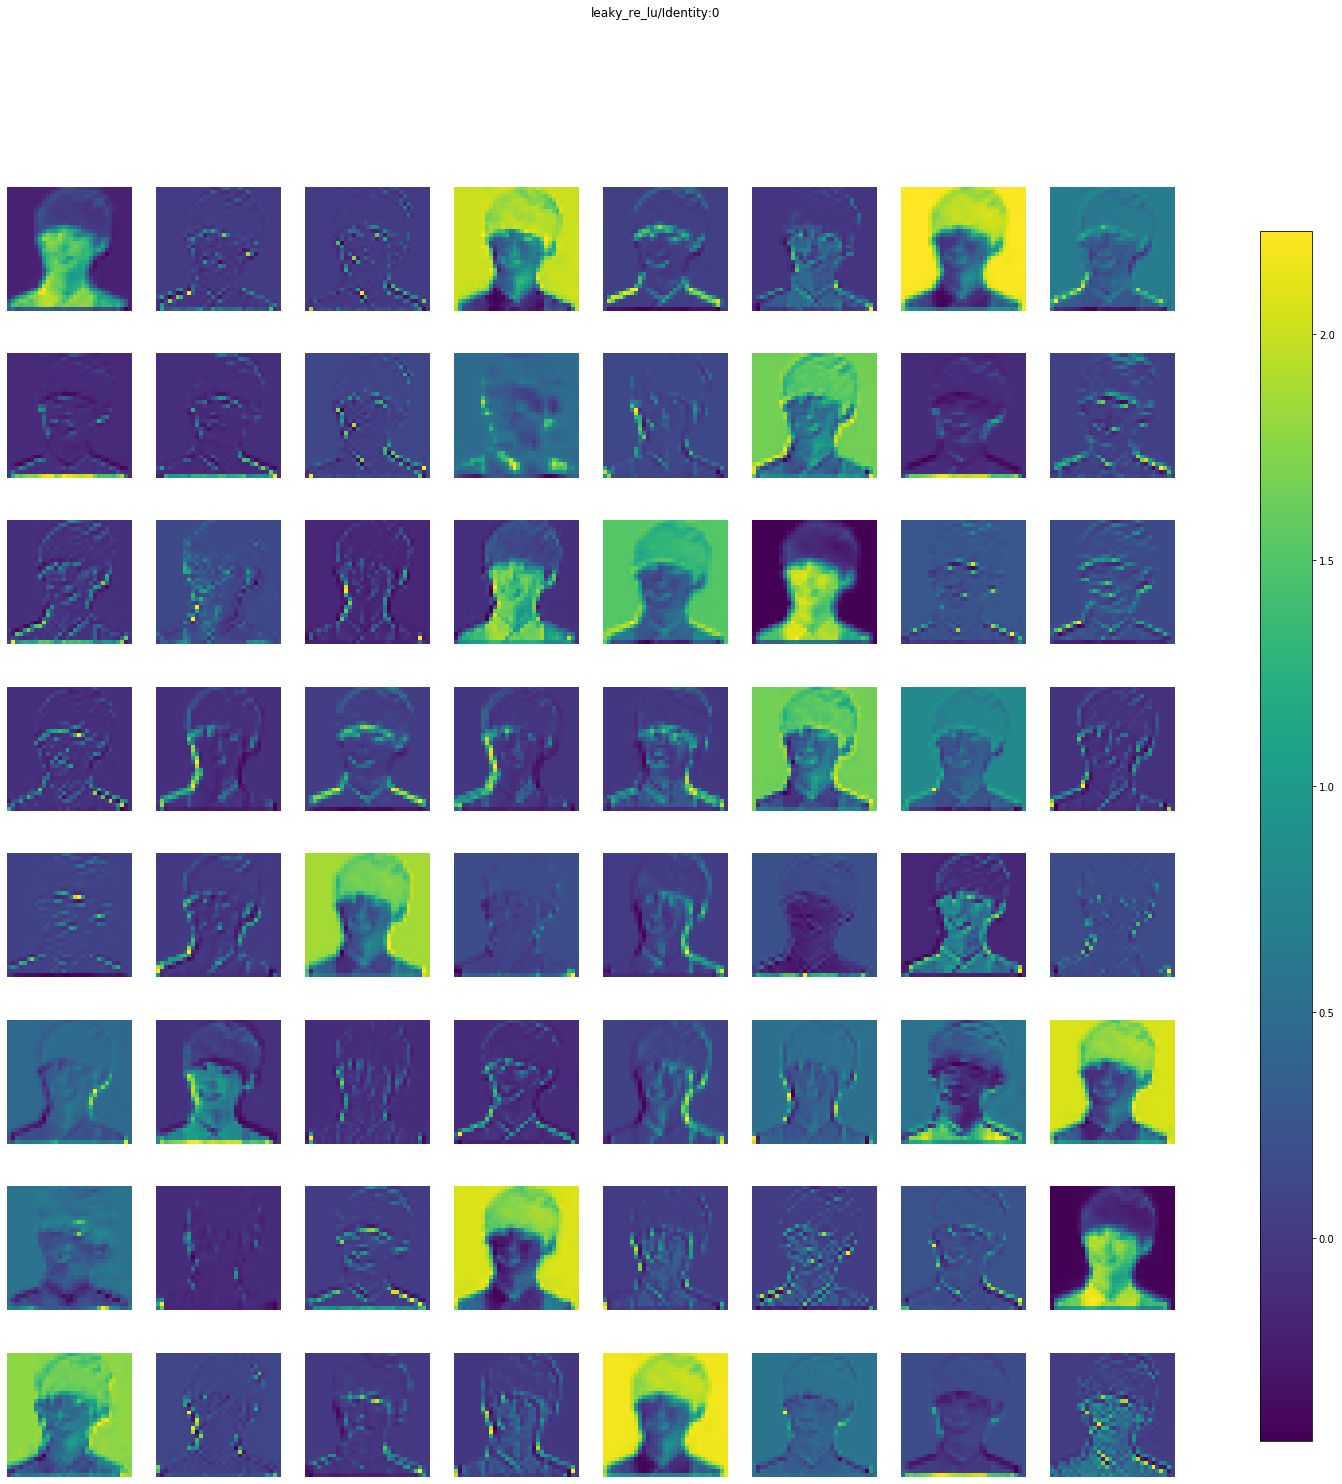

conv2d_1/Identity:0 (1, 16, 16, 128) 


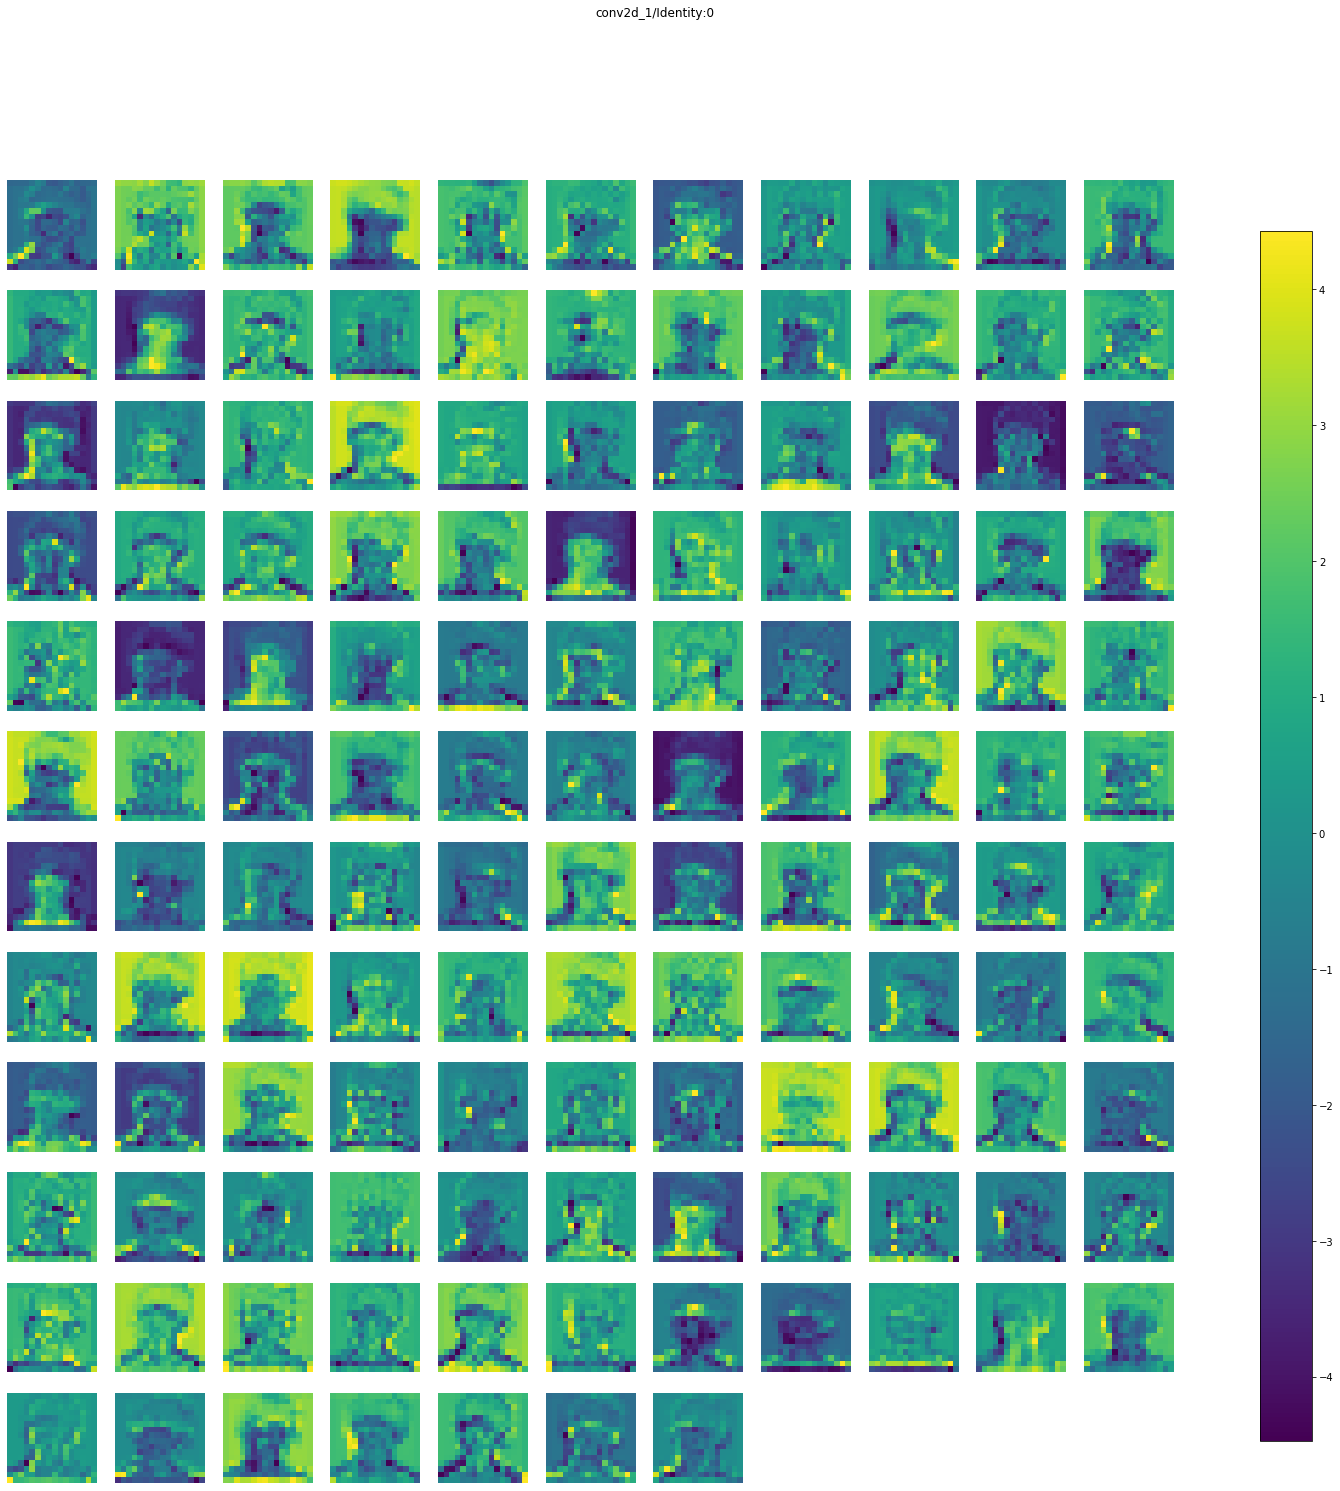

batch_normalization_5/Identity:0 (1, 16, 16, 128) 


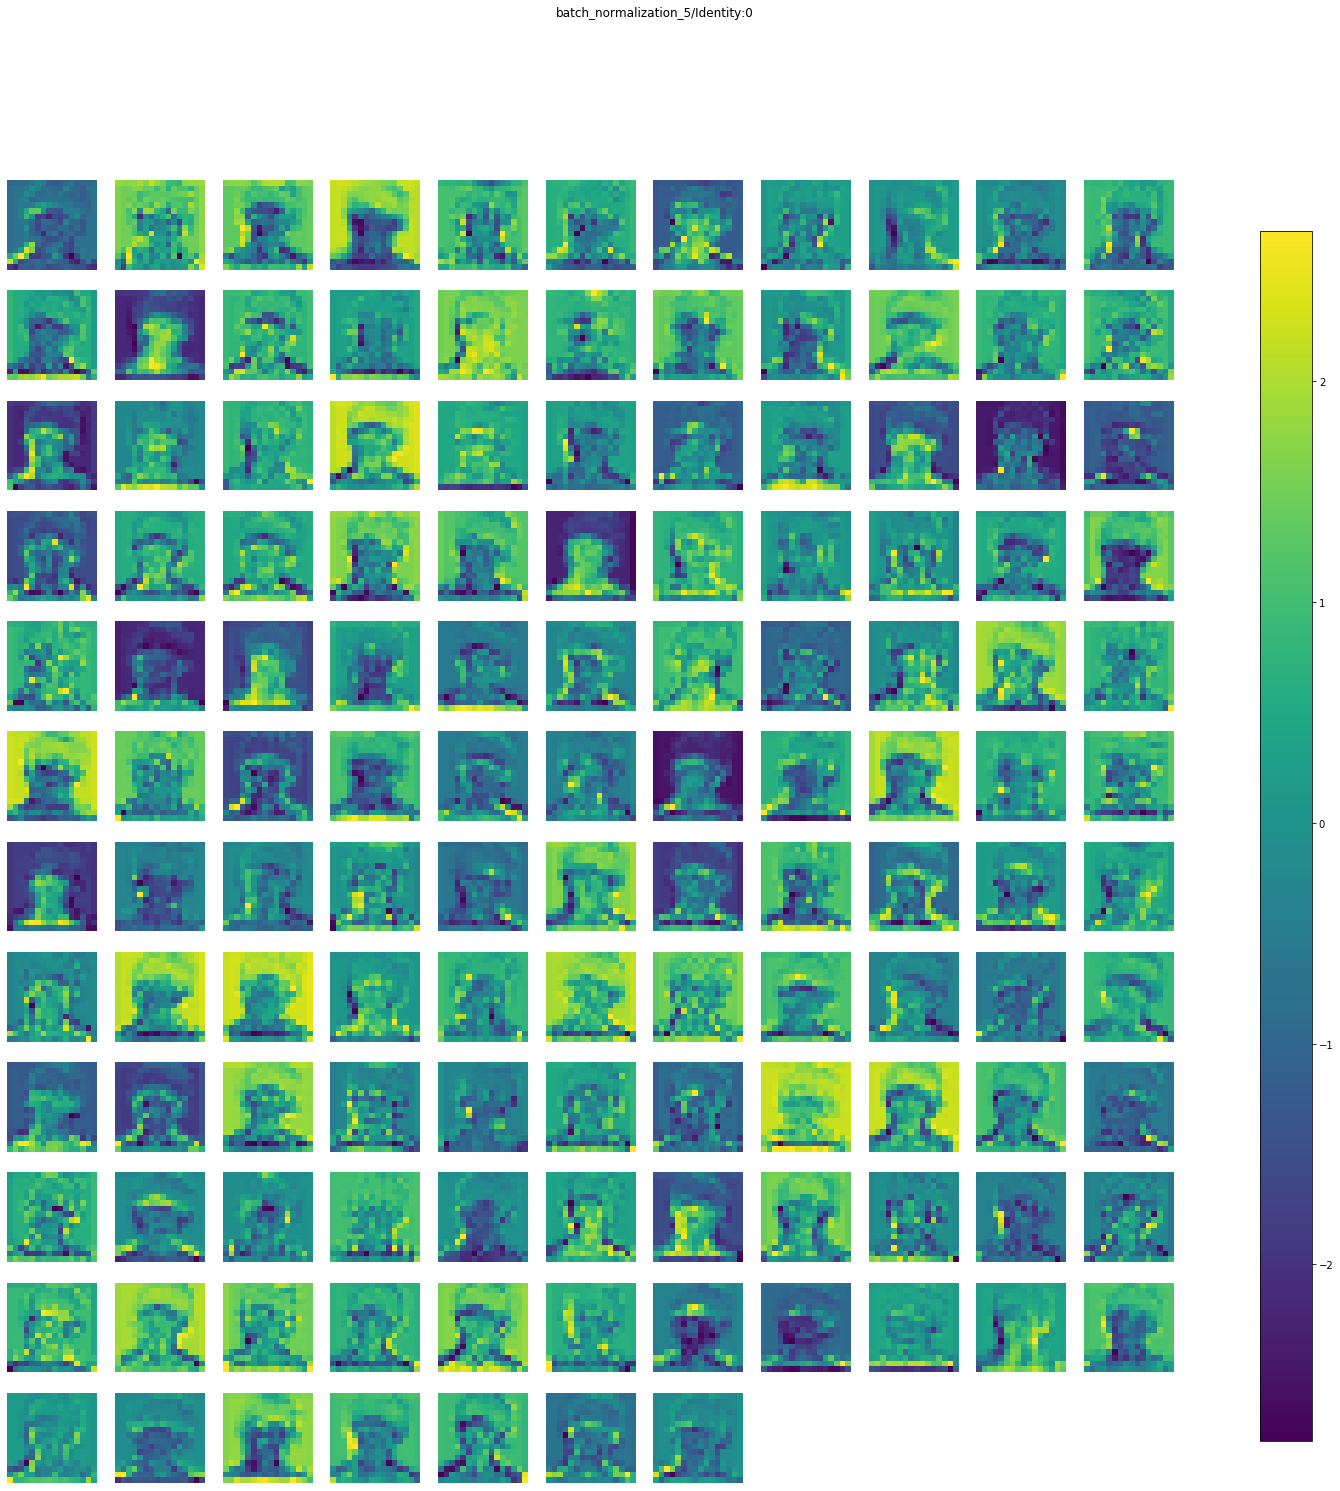

leaky_re_lu_1/Identity:0 (1, 16, 16, 128) 


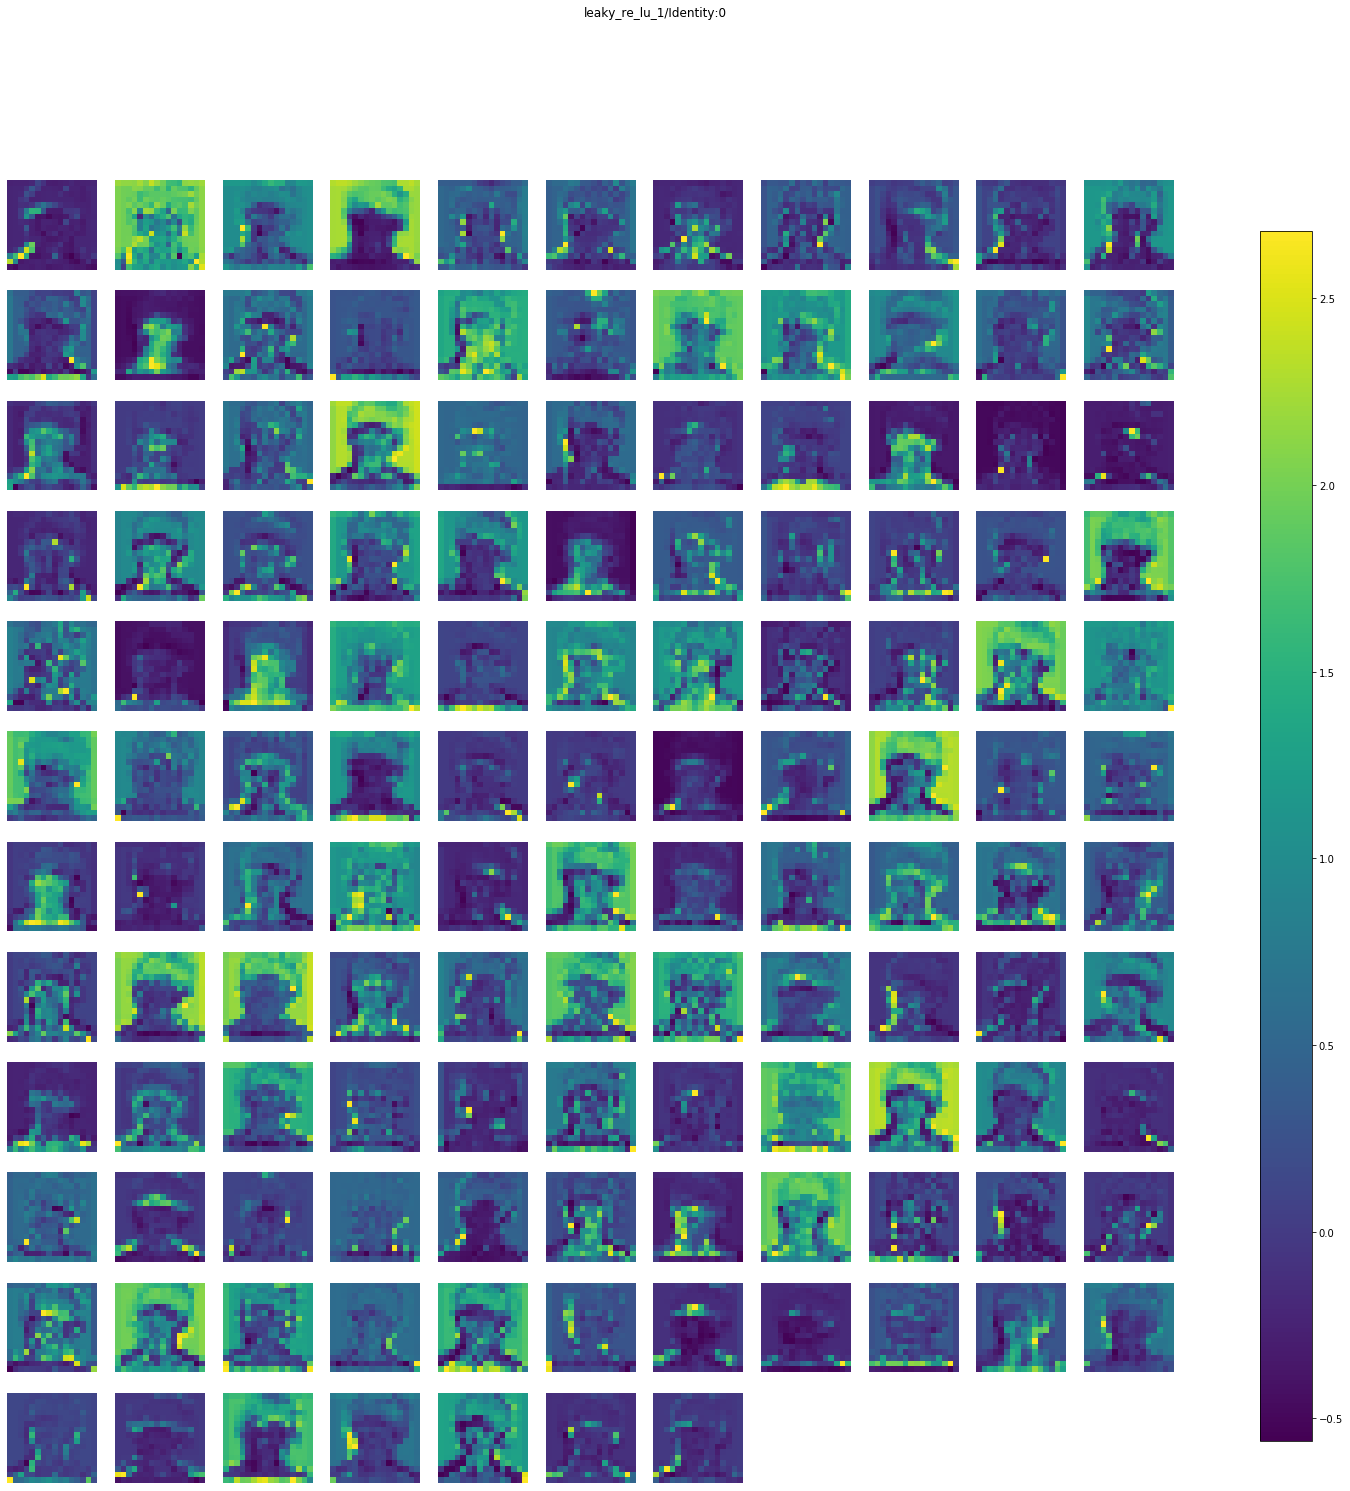

conv2d_2/Identity:0 (1, 8, 8, 256) 


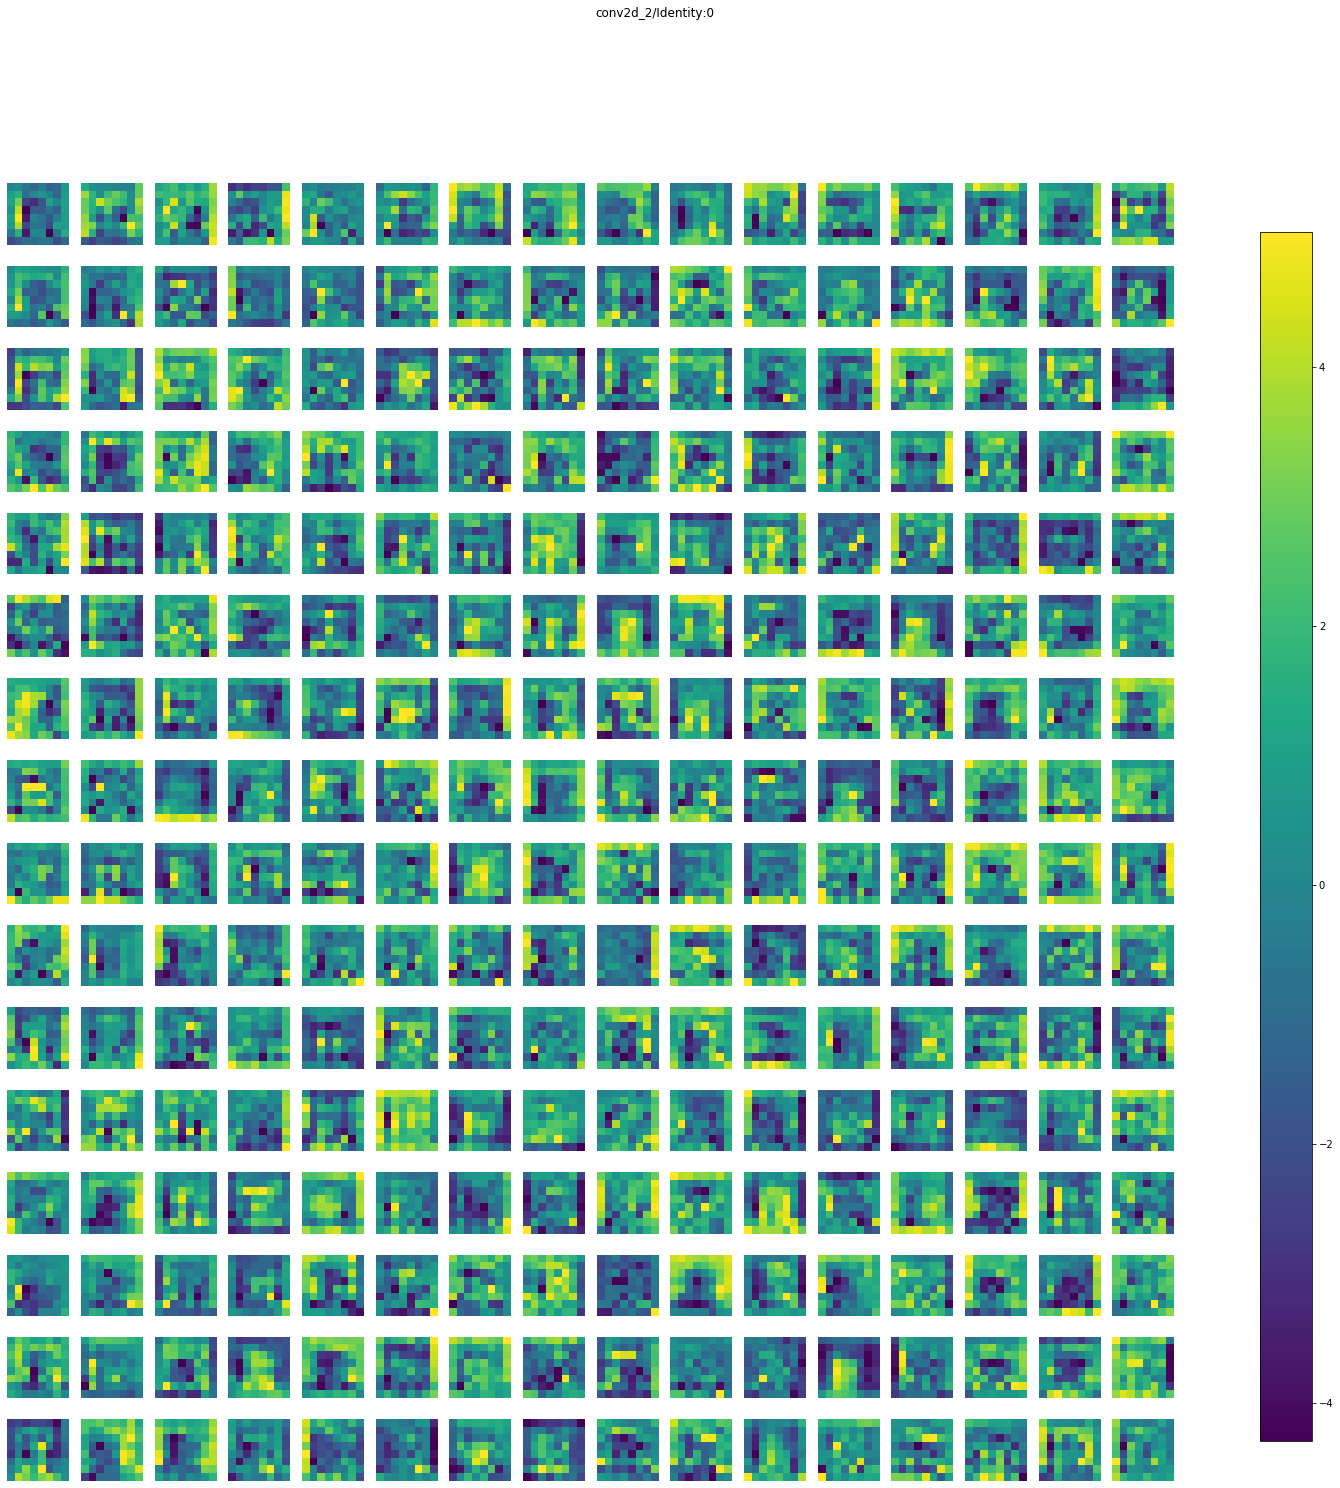

batch_normalization_6/Identity:0 (1, 8, 8, 256) 


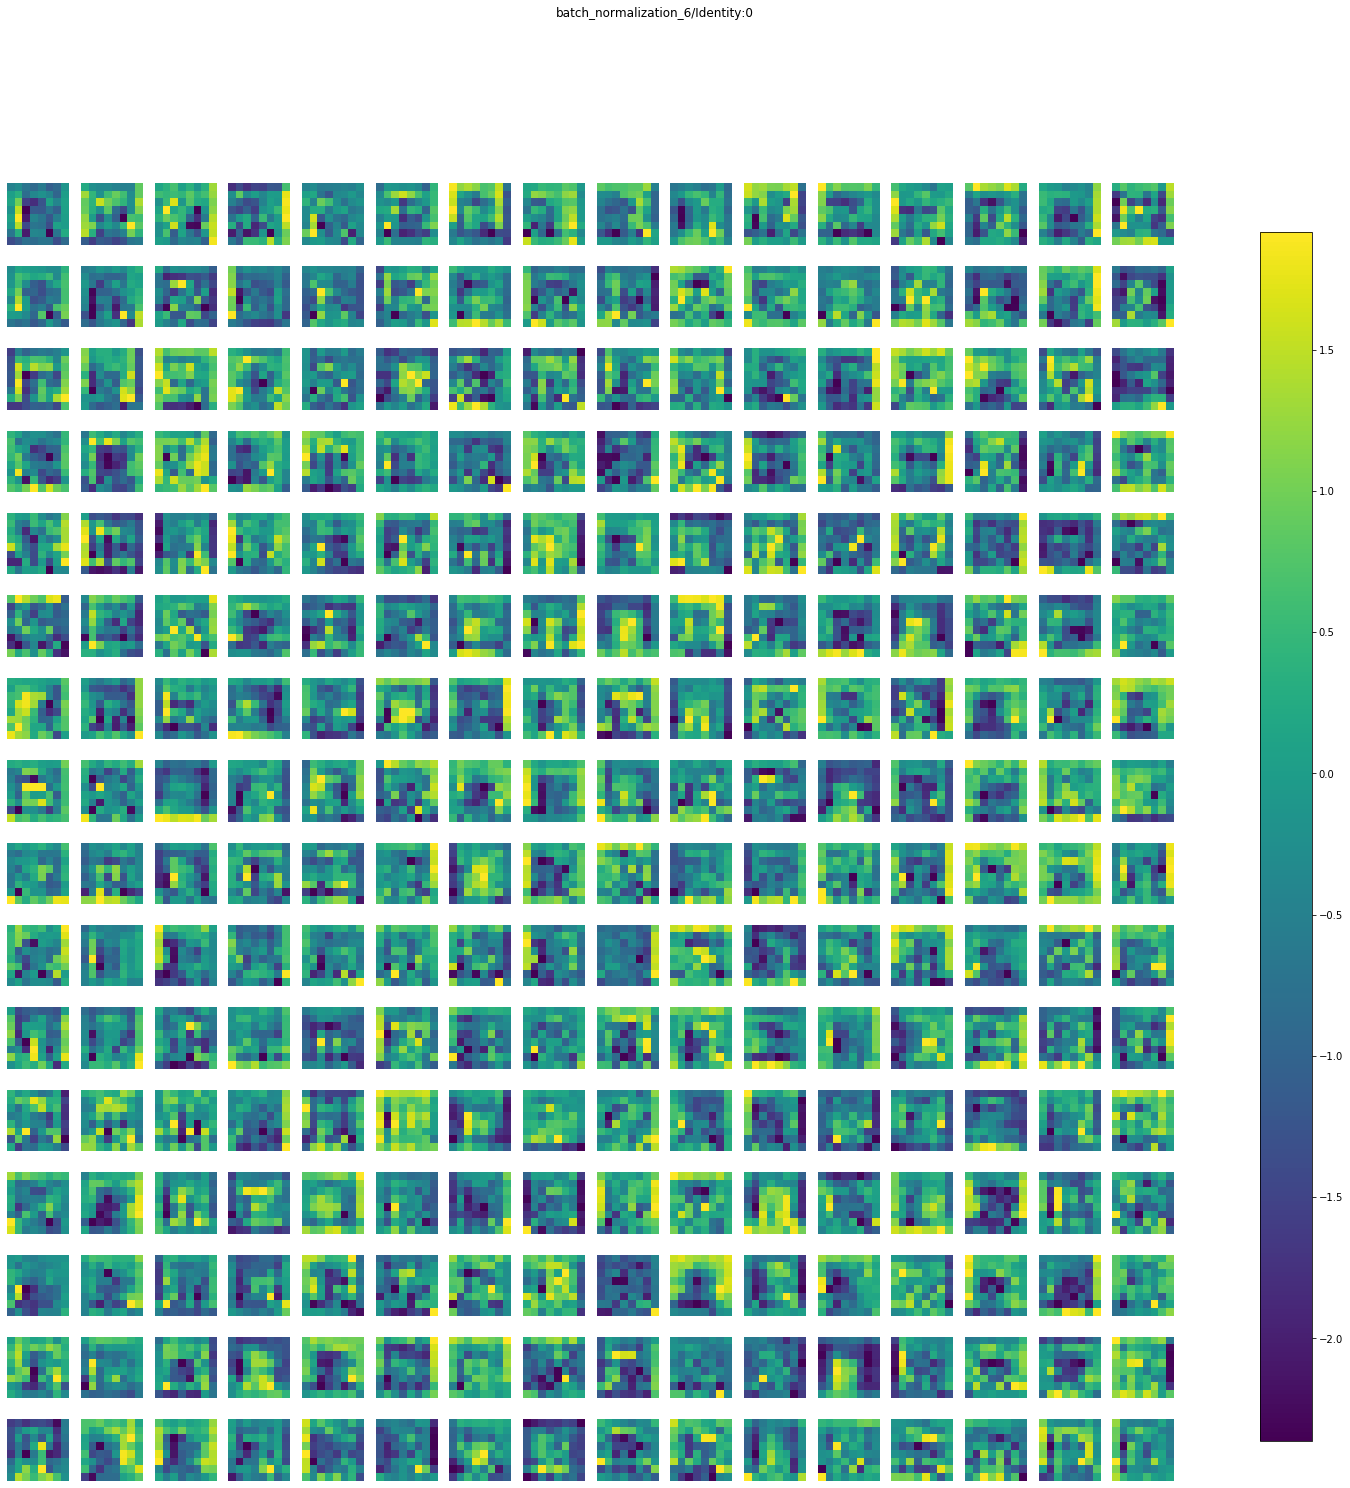

leaky_re_lu_2/Identity:0 (1, 8, 8, 256) 


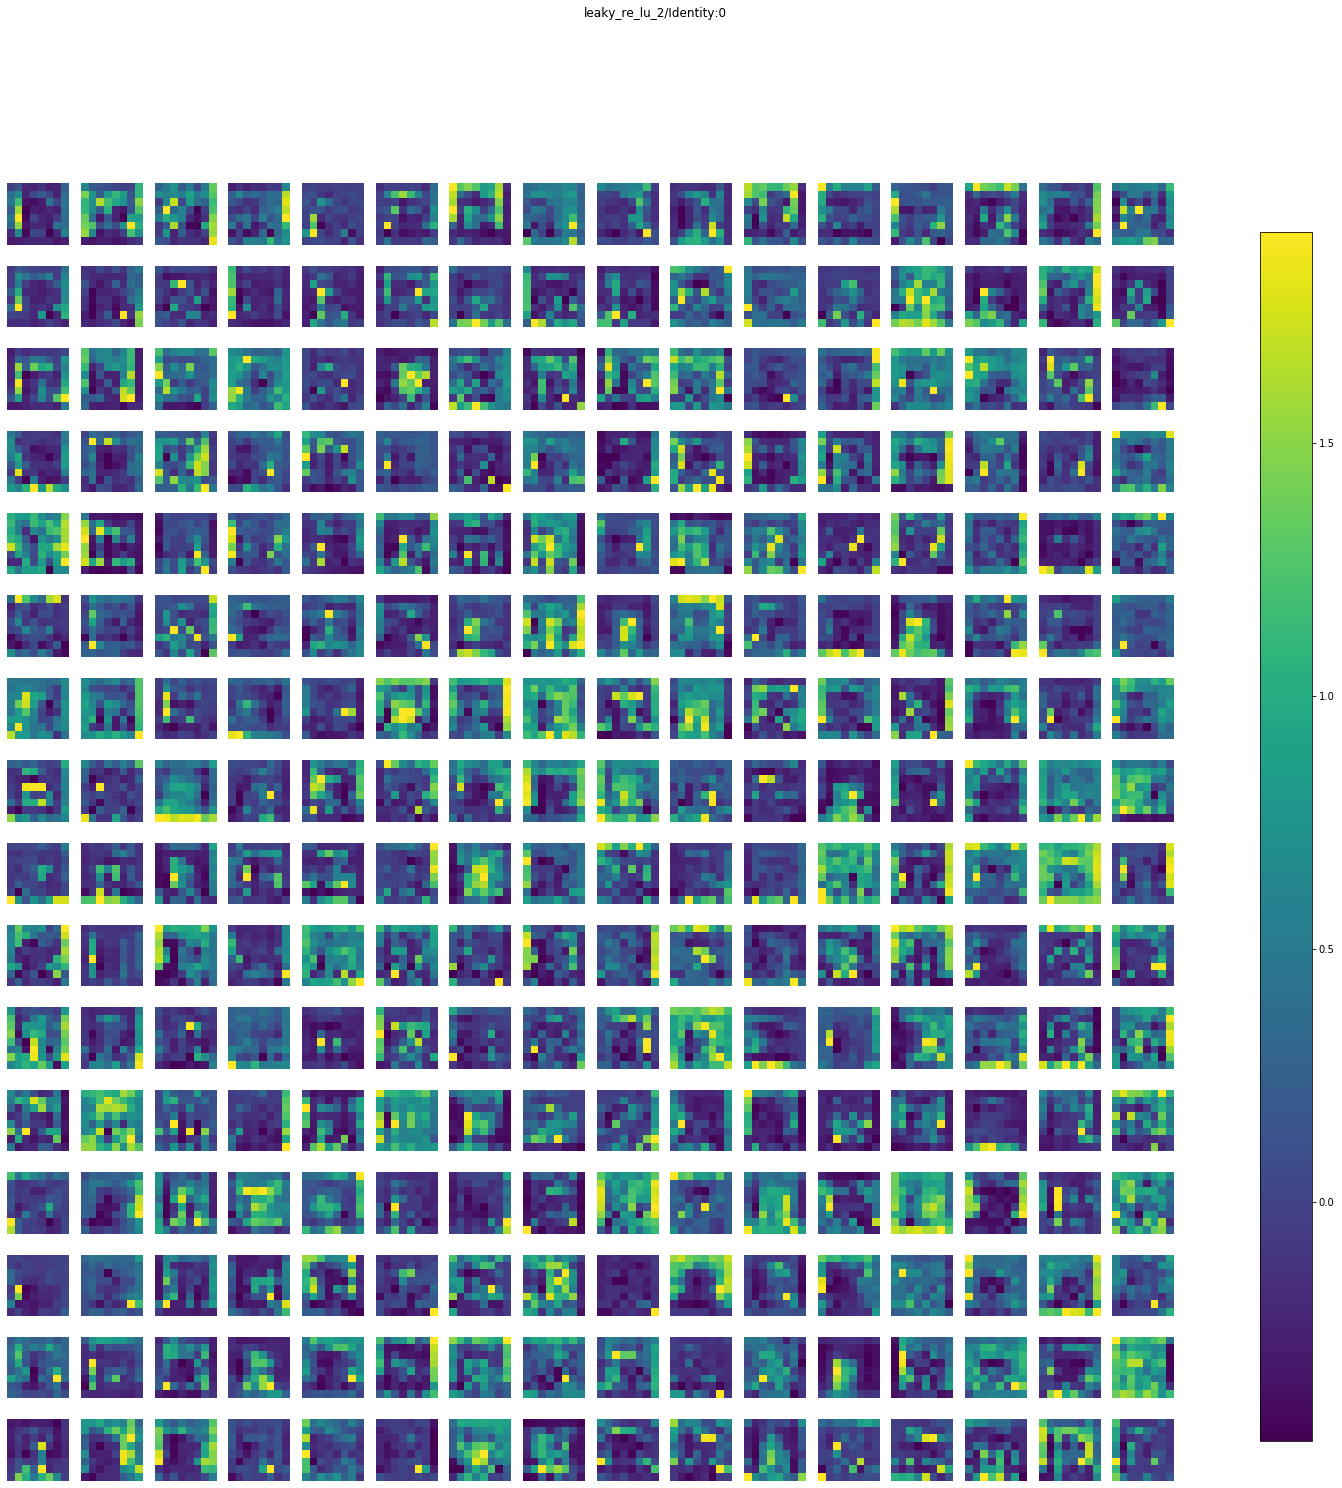

conv2d_3/Identity:0 (1, 4, 4, 512) 


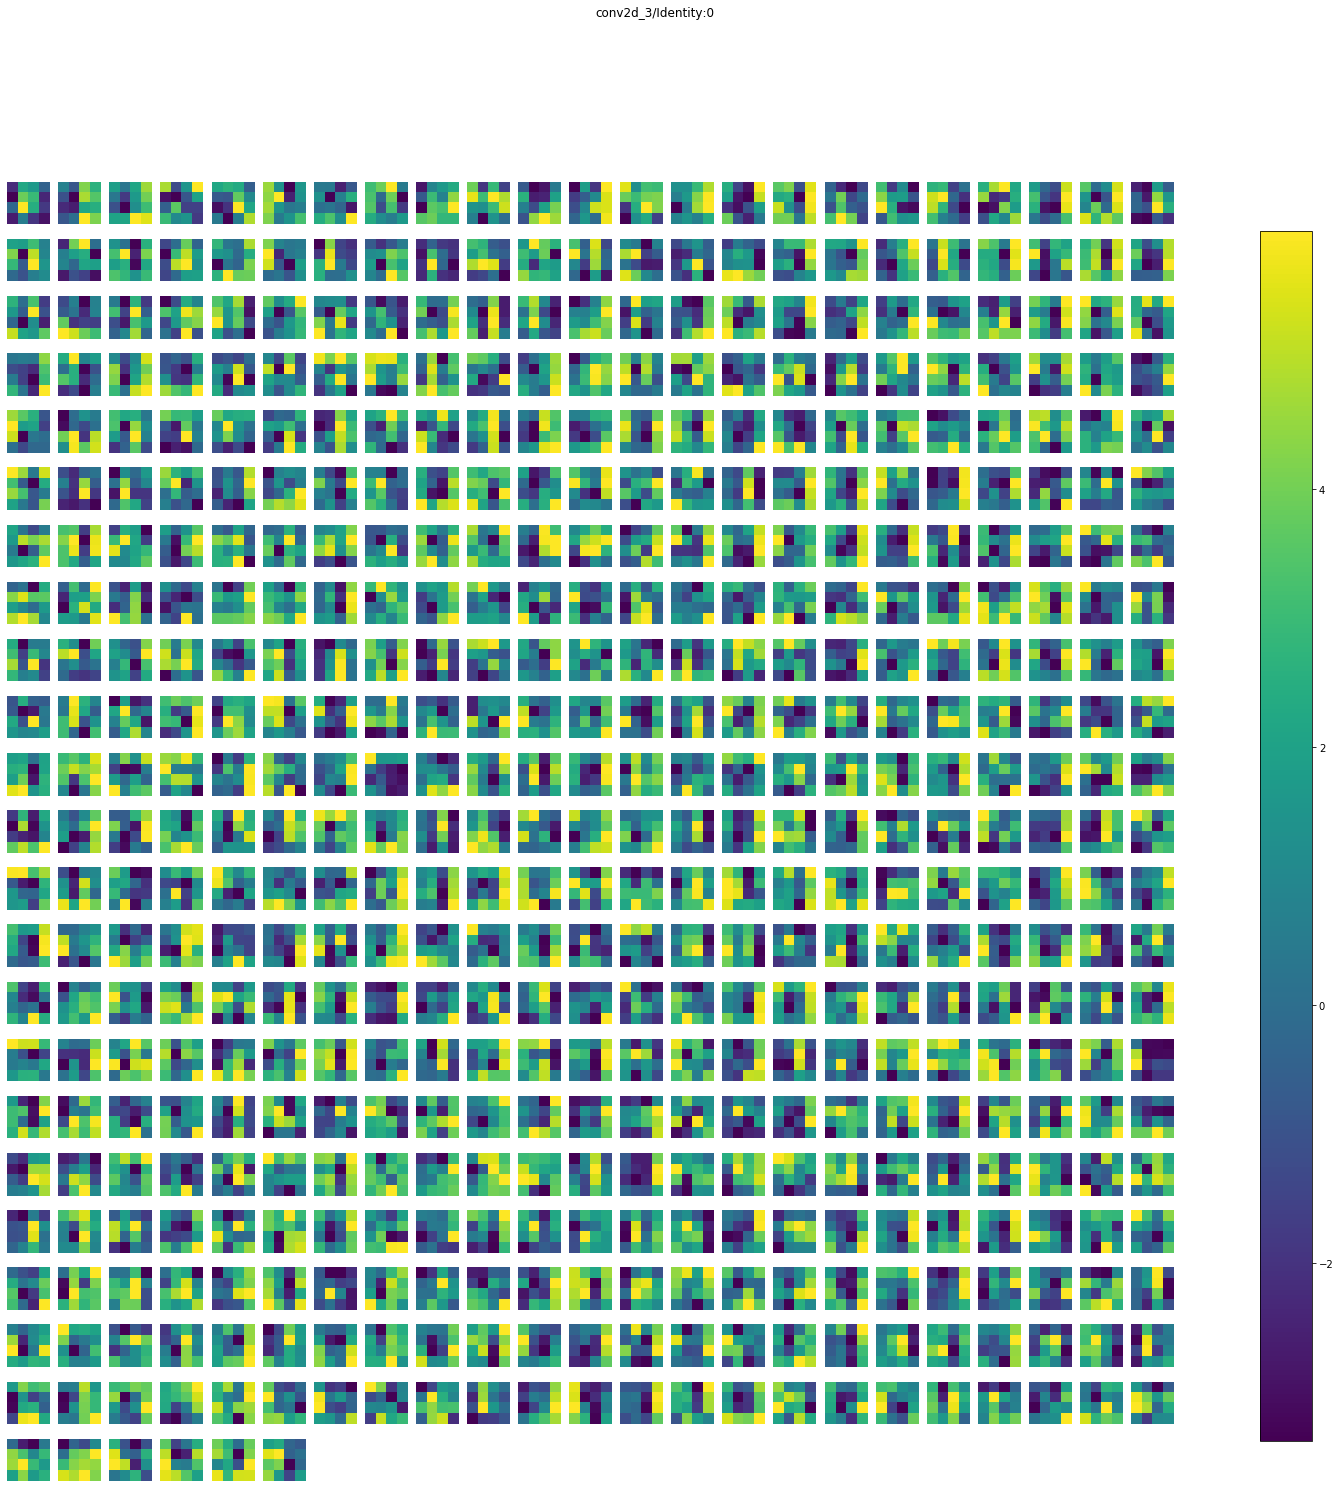

batch_normalization_7/Identity:0 (1, 4, 4, 512) 


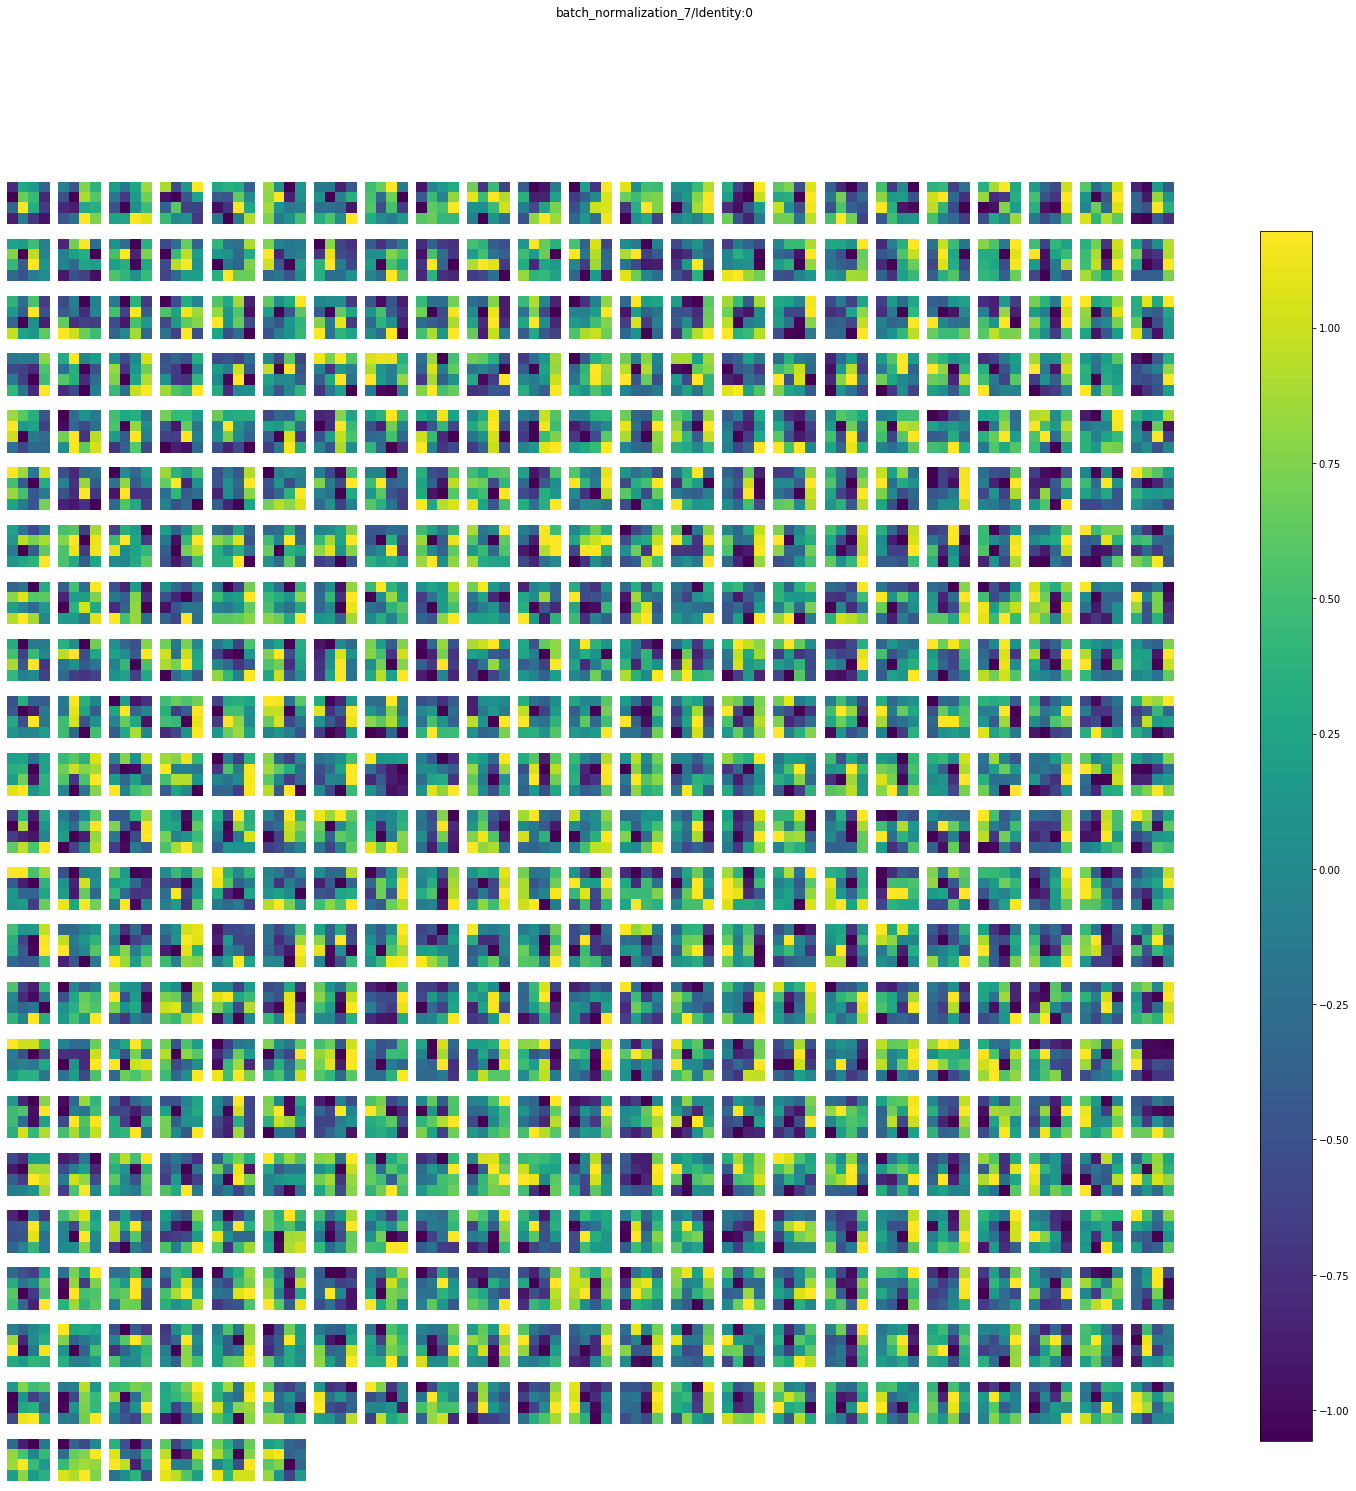

leaky_re_lu_3/Identity:0 (1, 4, 4, 512) 


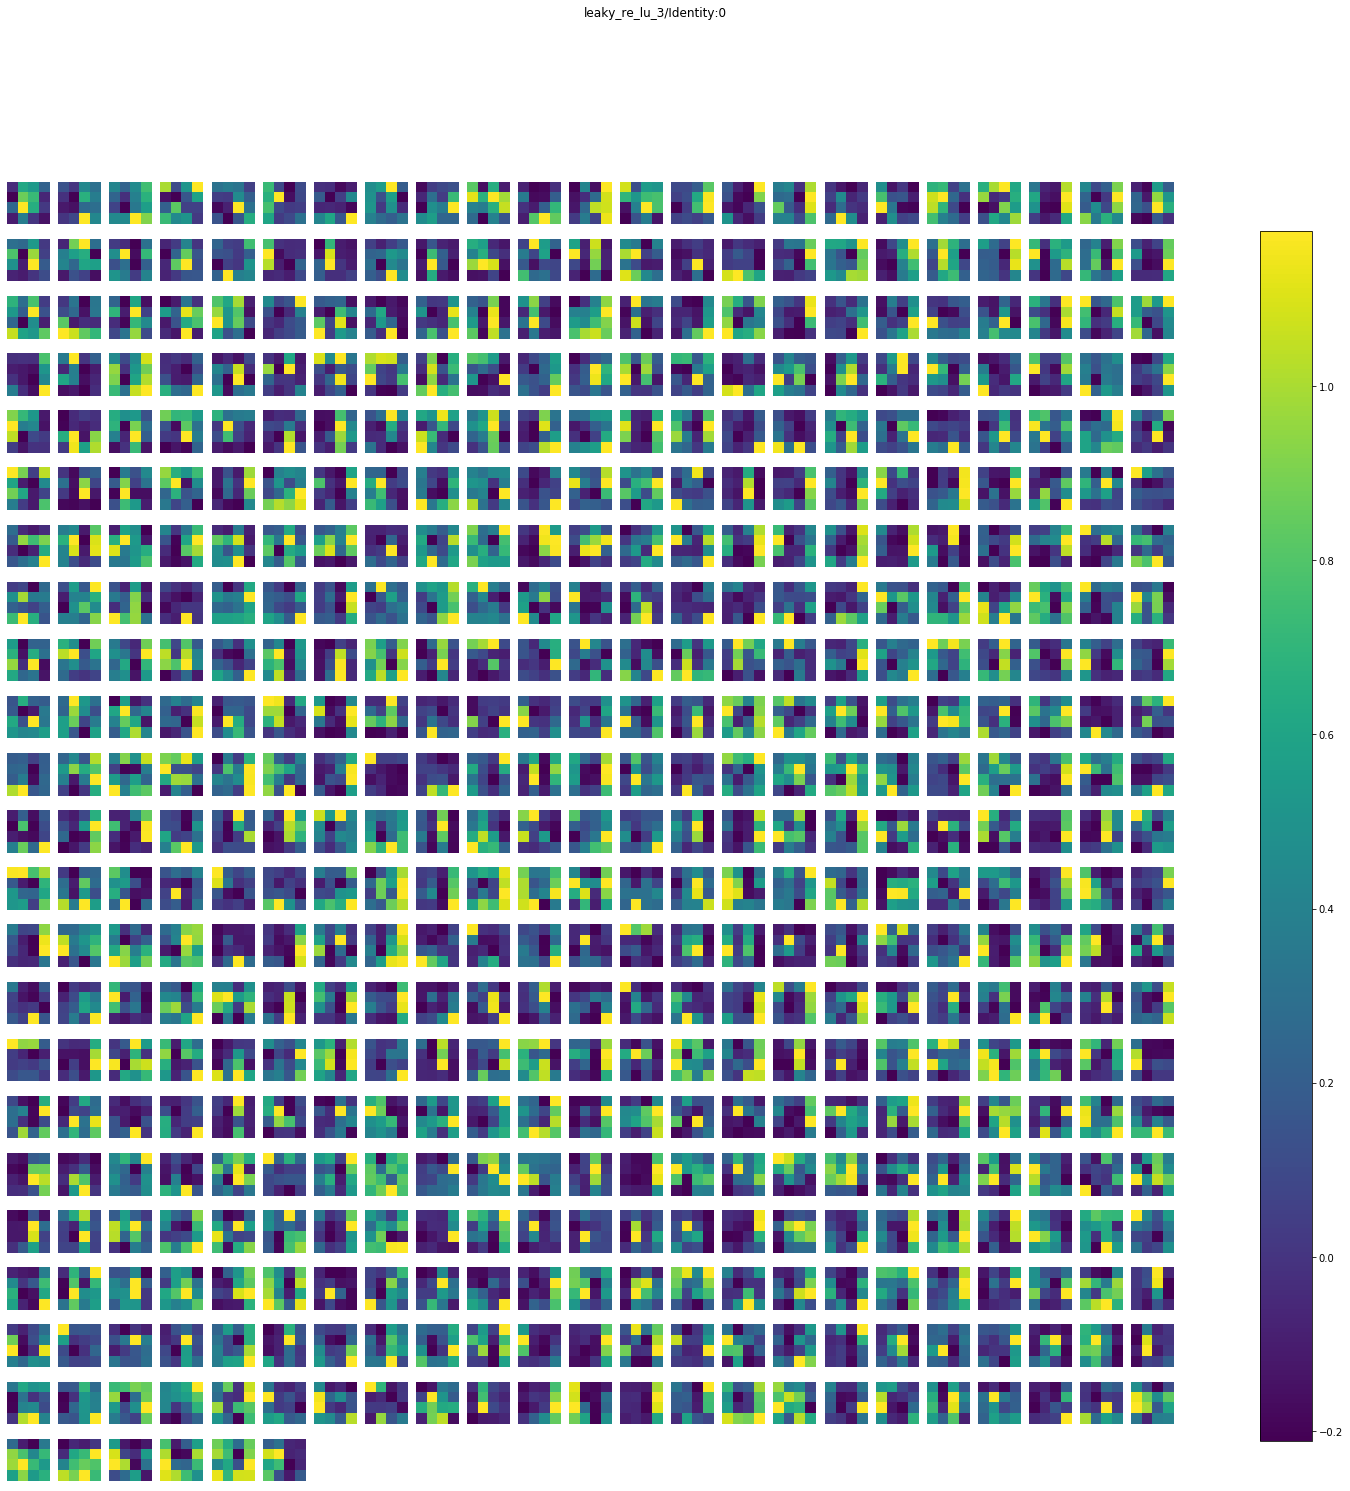

flatten/Identity:0 (1, 8192) 


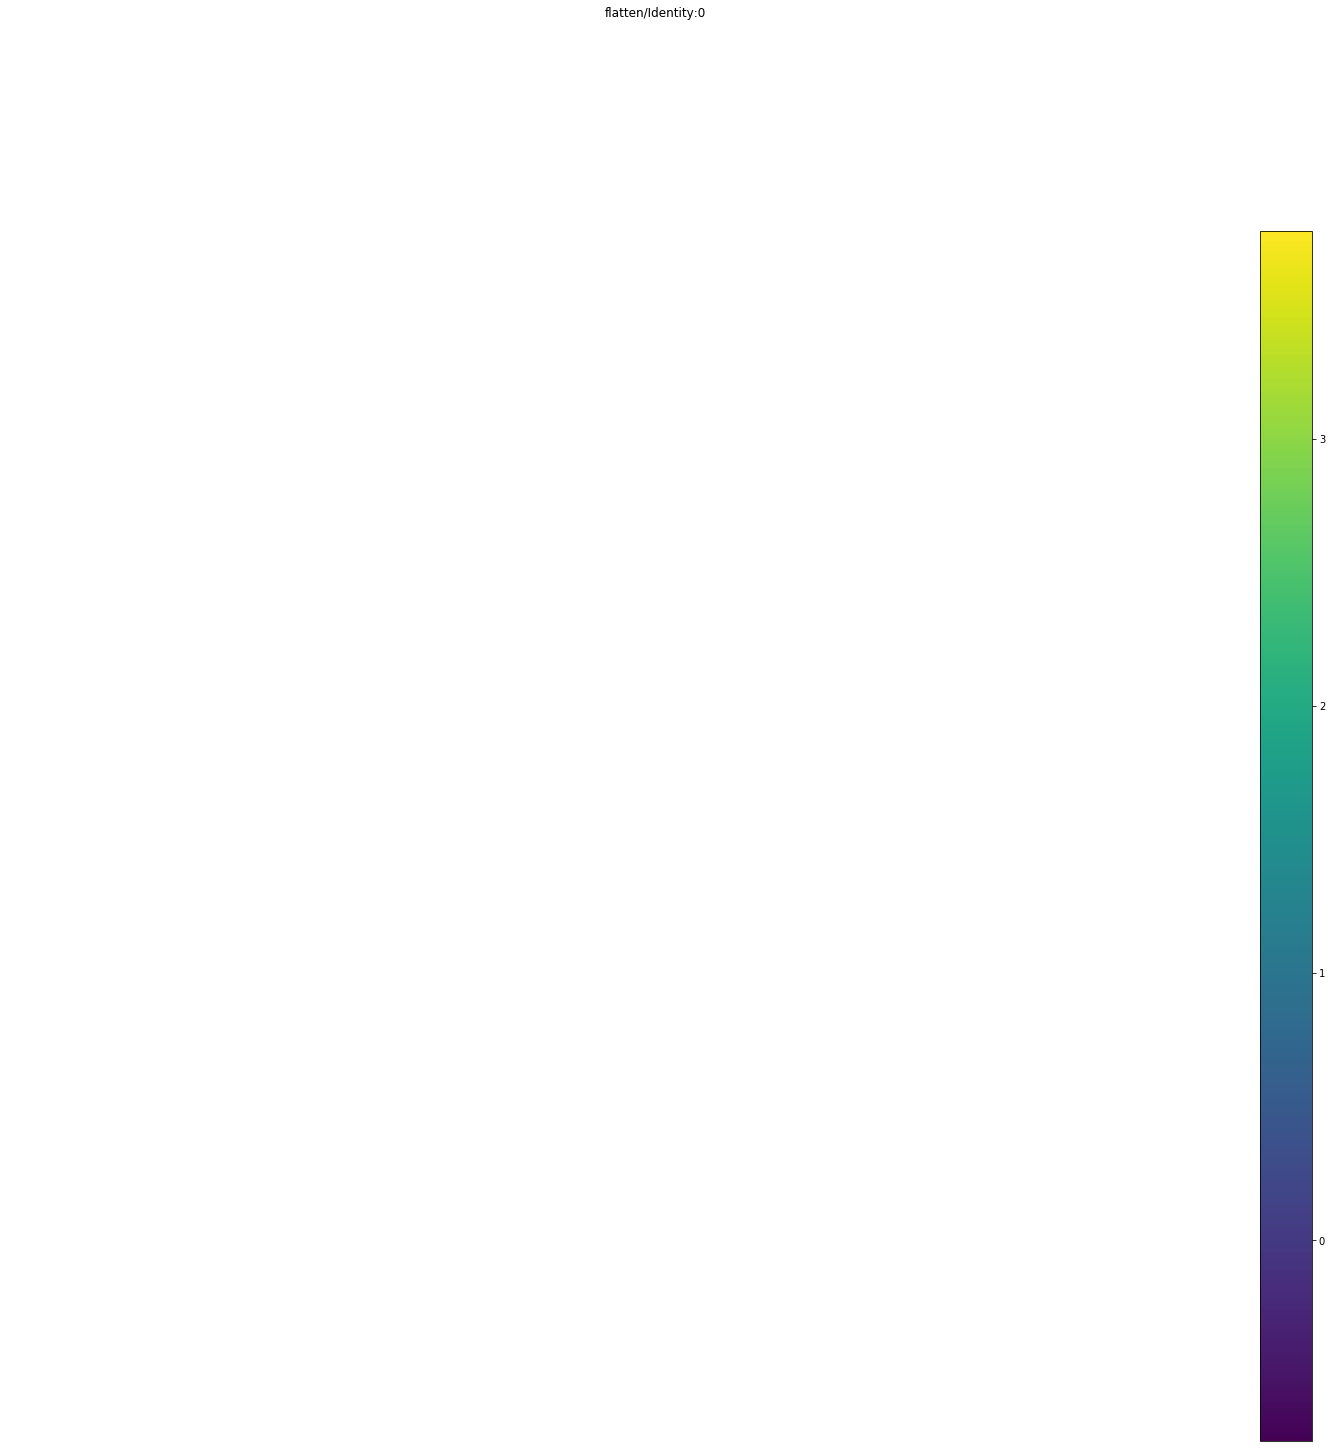

dense_1/Identity:0 (1, 1) 


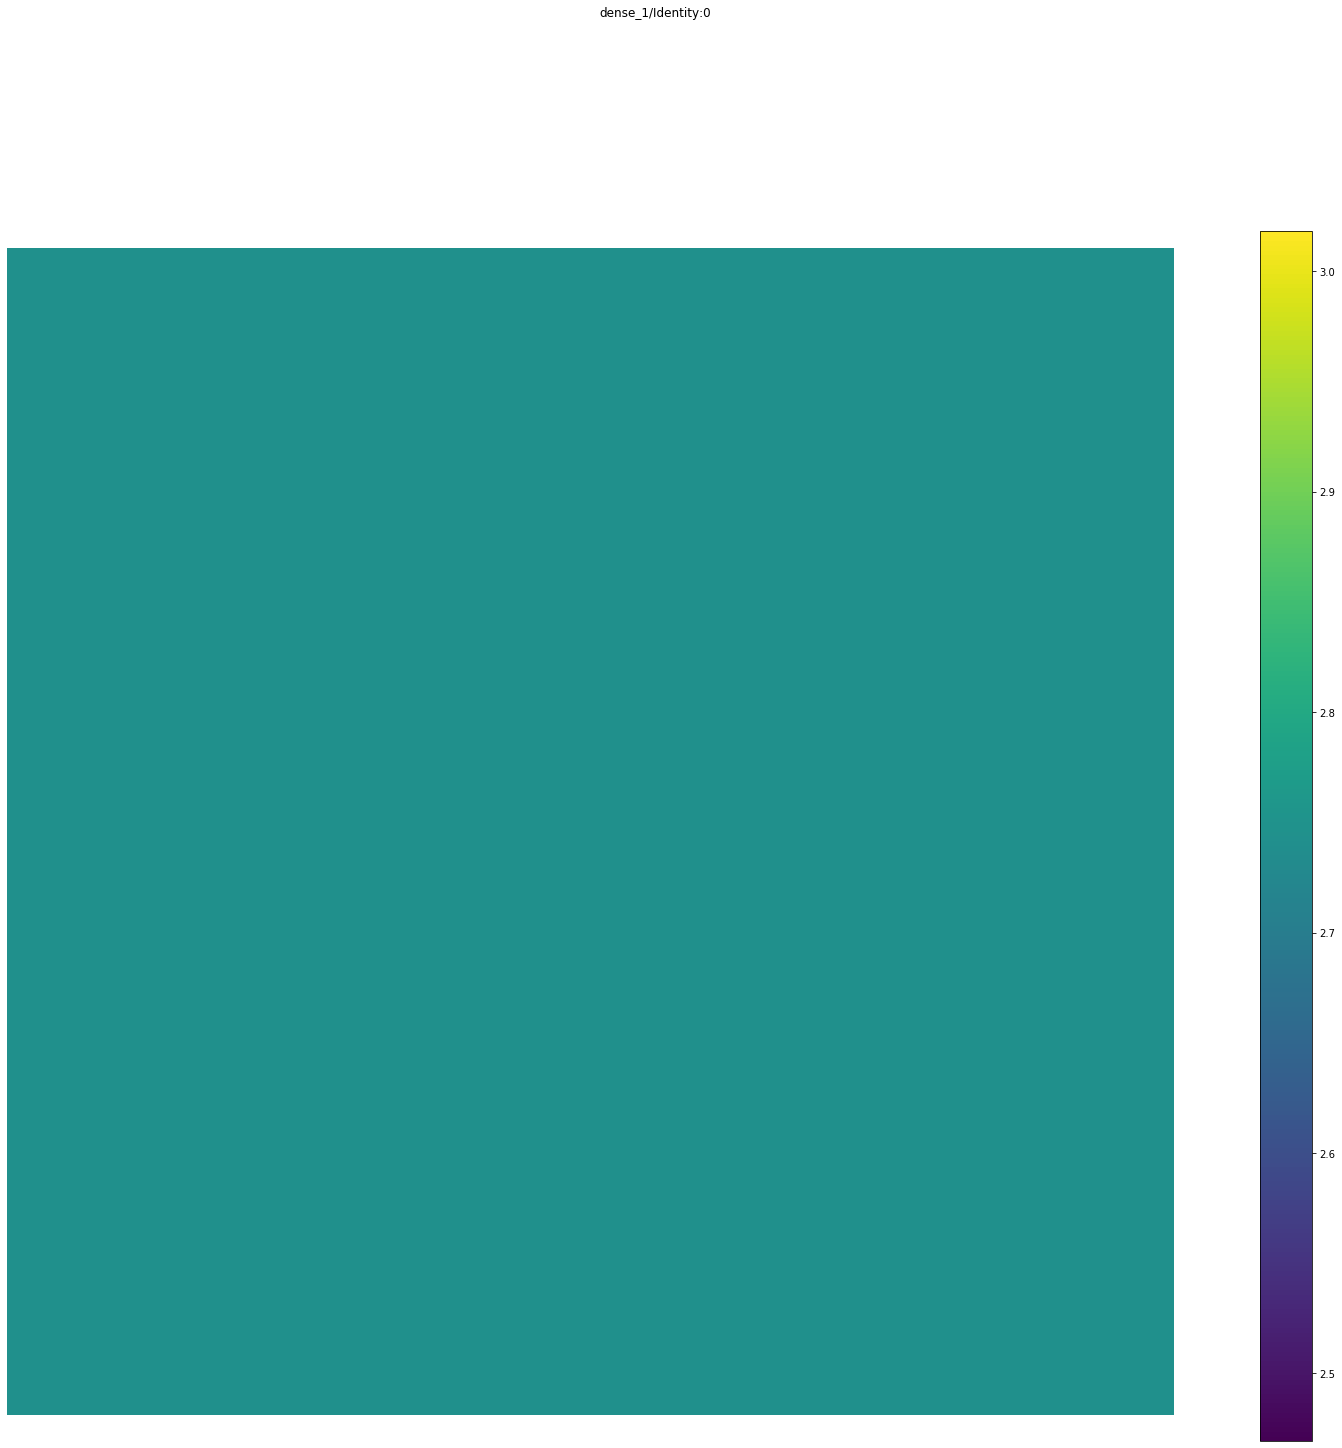

NameError: ignored

In [ ]:
from keract import display_activations
import time 
for img in datesets:
  img = (img + 1.0) / 2.0
  activations = get_activations(new_model, img)
  display_activations(activations, save=False)
  tims.sleep(5)